# Ray Tune

In this notebook we are going to explore the following topics:

- What is hyperparameter tuning?
- Core concepts to understand Ray Tune
- Getting started with Ray Tune
- Hyperparameter tuning using Ray (DL framework)
- Hyperparameter tuning using schedulers (ASHA)
- Bonus: Hyperparameter tuning using Ray (ML framework)

Reference: https://docs.ray.io/en/latest/tune/index.html

# What is hyperparameter tuning?

Firstly, it's important to understand what the hyperparameter tuning is and why it matters. 

**Hyperparameter tuning** is the process of finding the **best configuration** for your Machine Learning model, like choosing the right "settings" to get the best performance.

**Hyperparameters** are the parameters that are not learned from the data but are set **before** the training process begins. These parameters control the behavior of the learning algorithm and the structure of the model.

Examples of hyperparameters:
- *Learning rate*: determines how quickly the model adjusts its parameters during training.
- *Number of layers/neurons*: specifies the architecture of a neural network.
- *Batch size*: controls the number of samples processed before the model updates its parameters.
- *Number of trees*: Ffr ensemble models like Random Forests, this indicates the number of trees in the forest.
- *Regularization parameters*: controls overfitting by adding penalties (e.g., L1 or L2 regularization).

How does it work?

You train a model with **different combinations** of learning rate, number of layers, batch size, regularization parameters, ... and you measure performance (accuracy, loss) each time. The goal is to find the combination that gives the best result.

However, trying every combination manually or with loops is slow and inefficient, especially for big models or large datasets.

### What is Ray Tune?

Ray Tune is a scalable library for **hyperparameter tuning** and **experiment execution**. It is part of the Ray ecosystem and it allows users to optimize machine learning models by efficiently searching through hyperparameter spaces using various algorithms.

Ray Tune **automates and accelerates** hyperparameter tuning using **parallel execution** (running many trials simultaneously) and a **smart search** (using algorithms such as Bayesian, HyperOpt and ASHA to avoid wasting time on poor configurations).

### Why use Ray Tune?

- **Scalability**: easily scales from a single machine to a distributed cluster.
- **Flexibility**: supports various search algorithms (e.g., Grid Search, Random Search, Bayesian Optimization, Hyperband).
- **Integration**: works seamlessly with popular machine learning frameworks like TensorFlow, PyTorch, and scikit-learn.

# Core concepts

Main concepts to understand Ray Tune:

1. **Search Space**: defines the **hyperparameters** and their **possible values that Ray Tune** will explore during optimization. This could include parameters like learning rates, the number of layers in a neural network, or regularization strengths.This can be ranges, discrete options, or complex combinations.

2. **Trainable**: the **object** that Ray Tune uses **to run a trial**. It defines how to evaluate an objective function by combining hyperparameters and the computational process to calculate the objective value to be optimized. It essentially encapsulates the logic for training a model and reporting intermediate results to Ray Tune. This could be a function or a class.

3. **Search Algorithm**: the **strategy** for exploring the search space (e.g., random search, Bayesian optimization).

4. **Scheduler**: algorithms that help to **optimize resource usage** during hyperparameter tuning, often by stopping poor-performing trials early.

5. **Trials**: individual **runs** of the tuning process.

6. **ResultGrid**: collects the **results** of your experiment and provides utilities to inspect and analyze them. You can retrieve the best trial, view metrics, and even fetch configurations.





<div style="text-align: center;">
    <img src="Images/tune_flow.png" alt="Tune_flow" style="width:50%;">
    <p style="margin-top: 8px; text-align: center;"><em>Fig1: Core components of Ray Tune</em></p>

</div>

Now that we understand what hyperparameter tuning is and how Ray Tune works, let’s use Ray Tune to find the best settings for a simple model. You'll see how easy it is to go from slow manual tuning to distributed, optimized search.

# Getting started with Ray Tune

In [1]:
# Environment configuration
from datetime import datetime
import ray

# Ray Tune
from ray import tune
from ray.air import session

/leonardo_work/tra26_castiel2/mviscia1/ray_rag_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-29 12:42:58,384	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-01-29 12:42:59,676	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
!which python

/leonardo_work/tra26_castiel2/mviscia1/ray_rag_venv/bin/python


Connecting to the Ray cluster started previously.

In [3]:
ray.init(log_to_driver = False, ignore_reinit_error = True)

2026-01-29 12:43:00,069	INFO worker.py:1520 -- Using address 10.1.0.82:27667 set in the environment variable RAY_ADDRESS
2026-01-29 12:43:00,070	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.1.0.82:27667...
2026-01-29 12:43:00,079	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at http://10.1.0.82:8265 


Python version:,3.11.7
Ray version:,2.44.0
Dashboard:,http://10.1.0.82:8265


Check cluster resources

In [4]:
resources = ray.cluster_resources()

print(f"Cluster has {resources['CPU']} CPUs, {resources['GPU'] if 'GPU' in resources else 0} GPUs, execution memory {resources['memory'] * 1e-9} GBs, object storage memory {resources['object_store_memory'] * 1e-9} GBs")

Cluster has 16.0 CPUs, 2.0 GPUs, execution memory 359.45678684200004 GBs, object storage memory 154.05290864600002 GBs


Before we jump into tuning Machine Learning models, let’s start with something simple and visual.

Imagine we want to find the point closest to (3, 3) from a list of candidates. This has nothing to do with training models, but it will help us focus on how Ray Tune works:

*How do we define the trainable function?*

*How do we define the search space?*

*How do we evaluate each candidate?*

*How does Ray Tune find the best one?*

- ### Define all the ingredients to tune the hyperparameters

### 1) Define the trainable function:

The **trainable** is a flexible wrapper that can orchestrate processes like simulation, ML model training, or real-world optimization problems. Therefore, we define the **model training function** that we want to run variations of.

The trainable function:
- Takes in input a **dictionary with configurations of parameters** from Ray Tune. In this example, the dictionary contains the values of x and y that Ray Tune selects for that trial.
- Evaluates the model based on the **objective function** using the given parameters.
- **Reports** the dictionary results back to Ray Tune. The trainable will be executed on a separate Ray Actor (process), so we need to communicate the performance of the model back to Tune (which is on the main Python process).

In [5]:
# Example: finding the closest point to (3,3)

# Define the trainable function
def trainable(config): # The argument config is a dictionary containing the input parameters that Ray Tune will vary during the optimization process
    
    # Extract parameters from the config dict
    x = config["x"]
    y = config["y"]
    
    # Objective function: minimize the distance from (3, 3)
    loss = (x - 3)**2 + (y - 3)**2
    
    # Report the result to Ray Tune
    session.report({'loss':loss}) #train.report


### 2) Define a search space: 

The **search space** defines the parameter ranges for Ray Tune to explore. Ray supports various sampling techniques such as:
- `tune.uniform`: uniform distribution.
- `tune.grid_search`: exhaustive search over a grid.
- `tune.loguniform`: logarithmic distribution.
- `tune.choice`: choose one of these options uniformly

For this example, we'll search for parameters `x` and `y` within a defined range.

In [6]:
# Define the search space
# This tells Ray Tune which values it should explore for each parameter.

search_space = {
    "x": tune.uniform(-10, 10),  # Ray will sample 'x' from a uniform distribution between -10 and 10
    "y": tune.uniform(-10, 10),  # Similarly, 'y' will be sampled from -10 to 10
}

### 3) Execute hyperparameters tuning and generate trials

Using Ray Tune, we explore the search space to find the best configuration. 
- The `Tuner` object coordinates the tuning process.
- Specify the **metric** and **mode** to optimize (e.g., minimize `loss`).
- Specify the number of trials using `num_samples`. Tune automatically determines how many trials will run in parallel.

In [7]:
# Run the tuning process
tuner = tune.Tuner(
    trainable, # Trainable function
    param_space=search_space,  # Search space
    tune_config=tune.TuneConfig(
        metric="loss", 
        mode="min",
        # search_alg=search_algorithm, # Include search algorithm
        num_samples=15,  # Number of trials to run ## Try with different values, what happens if you setnum_samples=50?
    )
)

results = tuner.fit() # Execute and manage hyperparameter tuning and generate your trials

# Retrieve the best trial
best_result = results.get_best_result(metric="loss", mode="min")
print("Best configuration:", best_result.config)
print("Minimum loss:", best_result.metrics["loss"])

2026-01-29 12:43:08,053	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/leonardo/home/userinternal/mviscia1/ray_results/trainable_2026-01-29_12-43-02' in 0.0422s.
2026-01-29 12:43:08,061	INFO tune.py:1041 -- Total run time: 5.39 seconds (5.33 seconds for the tuning loop).


Best configuration: {'x': 4.044788577836298, 'y': 5.089966972308293}
Minimum loss: 5.459545117716688


By default, Ray Tune runs **N concurrent trials**, where **N** equals the number of **available CPUs** (cores) on your machine (you can set the maximu number of concurrent trials by specifying the parameter `max_concurrent_trials` inside the Tuner).

If you need to **customize the resource allocation per trial**, you can use `tune.with_resources`. This allows you to explicitly specify the resources (e.g., CPUs, GPUs, or memory) that each trial requires. You can provide these resource requests either as a dictionary or using a PlacementGroupFactory object.

For every trial, Ray Tune will attempt to create a placement group based on the specified resource requirements, ensuring that your trials run with the necessary resources.

In [8]:
%%script false --no-raise-error

# Specify resources to be used for each trial (if you have 8 CPUs on your machine, this will run 4 concurrent trials at a time)
trainable_with_resources = tune.with_resources(trainable, {"cpu": 2})

# Run the tuning process
tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(
        num_samples=10
    )
)

results = tuner.fit()

In [9]:
%%script false --no-raise-error

# Specify resources to be used for each trial (if you have 8 CPUs and 1 GPU on your machine, this will run 1 trial at a time)
trainable_with_resources = tune.with_resources(trainable, {"cpu": 2, "gpu":1})

# Run the tuning process
tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(
        num_samples=10
    )
)

results = tuner.fit()

We can also specify the **search algorithm** as an input in the `Tuner` (default to random search). In this example we're using `HyperOptSearch`, a search algorithm plugin for Ray Tune that wraps the `Hyperopt` optimization library, a widely-used library for Bayesian optimization. It helps Ray Tune to choose parameter values intelligently over time by learning from previous trials, rather than of just trying random configurations.

In [10]:
%%script false --no-raise-error

from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch 

# Define the search algorithm
search_algorithm = HyperOptSearch(
    metric="loss",
    mode="min",
    n_initial_points=16
)

search_algorithm = ConcurrencyLimiter(search_algorithm, max_concurrent=4)


# Run the tuning process
tuner = tune.Tuner(
    trainable, # Trainable function
    param_space=search_space,  # Search space
    tune_config=tune.TuneConfig(
        search_alg=search_algorithm, # Include search algorithm
        num_samples=10,  # Number of trials to run,
    )
)

results = tuner.fit() # Execute and manage hyperparameter tuning and generate your trials

# Retrieve the best trial
best_result = results.get_best_result(metric="loss", mode="min")
print("Best configuration:", best_result.config)
print("Minimum loss:", best_result.metrics["loss"])

Note that HyperOptSearch has an internal parallelism constraint.

# Hyperparameter tuning using Ray (DL framework)

In the following example, we'll explore the use of Ray Tune for hyperparameter tuning in a Deep Learning framework. In particular, we'll see how to implement a tuning process for a **PyTorch Lightning classifier** on a CIFAR-10 dataset.

The **CIFAR-10** dataset consists of 60,000 32x32 color **images** in **10 classes** (6,000 images per class). It is widely used in computer vision research. The 10 classes include airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

The neural network aims to **classify** the images into one of the 10 categories. It takes a 32x32 image as input, processes it through a sequence of layers, and outputs a probability distribution over the 10 classes. The network’s performance is evaluated using cross-entropy loss, a common metric for classification tasks.

In [11]:
# Ray Tune on ML framework
import time
import xgboost as xgb
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from ray.tune.search.hyperopt import HyperOptSearch
import numpy as np

# Ray Tune on DL framework
import os
from ray.train.torch import TorchTrainer
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import ray.train.lightning
import torch
import time
from torch import nn
from ray.tune.schedulers import ASHAScheduler

2026-01-29 12:43:12,714	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [12]:
# Define the PyTorch Lightning model
class CIFAR10Classifier(pl.LightningModule):
    def __init__(self, hidden_size, lr):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
        )
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True) #, sync_dist=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Define the training function for Ray Tune
def train_func(train_loop_config):  # config
    config = train_loop_config # elimina
    # Data preparation
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    data_dir = "/leonardo_scratch/fast/tra26_castiel2/data/data_cifar10"
    dataset = datasets.CIFAR10(root=data_dir, train=True, transform=transform, download=False)
    train_dataset, val_dataset = random_split(dataset, [45000, 5000])
    train_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=int(config["batch_size"]))

    # Define the model
    model = CIFAR10Classifier(hidden_size=config["hidden_size"], lr=config["lr"])
  
    # Define the PyTorch Lightning trainer
    trainer = pl.Trainer(
        devices="auto",
        accelerator="auto",
        strategy=ray.train.lightning.RayDDPStrategy(),
        max_epochs=10,
        plugins=[ray.train.lightning.RayLightningEnvironment()],
        callbacks=[ray.train.lightning.RayTrainReportCallback()],
        # [1a] Optionally, disable the default checkpointing behavior
        # in favor of the `RayTrainReportCallback` above.
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
    )

    # Train the model
    trainer = ray.train.lightning.prepare_trainer(trainer)
    trainer.fit(model, train_loader, val_loader)

In [13]:
start_time =time.time()

checkpoint_dir = "/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint" ### Change to '/leonardo_scratch/large/userexternal/<your HPC username>'

scaling_config = ray.train.ScalingConfig(
    num_workers=2,              
    use_gpu=True,               
    resources_per_worker={      
        "CPU": 6,               
        "GPU": 1
    }
)

# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_loop_per_worker=train_func, #train_func
    scaling_config=scaling_config,
    run_config=ray.train.RunConfig(storage_path=checkpoint_dir)
)

# Define the hyperparameter search space
search_space = {
    "hidden_size": tune.choice([128, 256, 512]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([32, 64, 128]),
}

# Trigger hyperparameter tuning with Ray Tune
tuner = tune.Tuner(
    ray_trainer, #tune.with_parameters(train_func),
    param_space={"train_loop_config": search_space}, #param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="train_loss",
        mode="min",
        num_samples=4,  # Number of trials
        # max_concurrent_trials=2
    ),
)

results = tuner.fit()

end_time = time.time()
best_result = results.get_best_result(metric="train_loss", mode="min")
comp_time = end_time-start_time

2026-01-29 12:48:36,276	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/leonardo_scratch/large/userinternal/mviscia1/ray_checkpoint/TorchTrainer_2026-01-29_12-43-18' in 0.0083s.
2026-01-29 12:48:36,281	INFO tune.py:1041 -- Total run time: 318.24 seconds (318.22 seconds for the tuning loop).


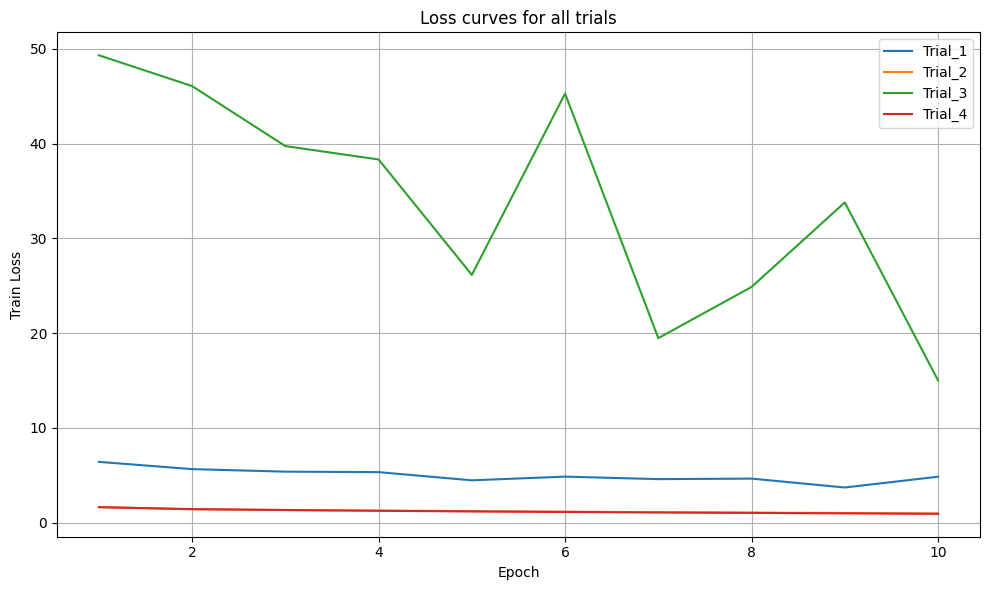

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

all_metrics = []

for i, result in enumerate(results):
    df = result.metrics_dataframe.copy()
    df["trial_id"] = f"Trial_{i+1}"
    df["config"] = str(result.config)
    all_metrics.append(df)

all_results_df = pd.concat(all_metrics, ignore_index=True)

plt.figure(figsize=(10, 6))

# Group by trial and plot
for trial_id, trial_df in all_results_df.groupby("trial_id"):
    plt.plot(trial_df["training_iteration"], trial_df["train_loss"], label=trial_id)

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Loss curves for all trials")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
df.head()

,train_loss,epoch,step,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,...,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/hidden_size,config/train_loop_config/lr,config/train_loop_config/batch_size,config
0,1.640035,0,176,1769687279,checkpoint_000000,True,False,1,Trial_4,2026-01-29_12-47-59,...,16.496177,2607526,lrdn0082.leonardo.local,10.1.0.82,16.496177,1,512,0.000524,128,"{'train_loop_config': {'hidden_size': 512, 'lr..."
1,1.433246,1,352,1769687283,checkpoint_000001,True,False,2,Trial_4,2026-01-29_12-48-03,...,20.433736,2607526,lrdn0082.leonardo.local,10.1.0.82,20.433736,2,512,0.000524,128,"{'train_loop_config': {'hidden_size': 512, 'lr..."
2,1.339727,2,528,1769687287,checkpoint_000002,True,False,3,Trial_4,2026-01-29_12-48-07,...,24.356834,2607526,lrdn0082.leonardo.local,10.1.0.82,24.356834,3,512,0.000524,128,"{'train_loop_config': {'hidden_size': 512, 'lr..."
3,1.261192,3,704,1769687290,checkpoint_000003,True,False,4,Trial_4,2026-01-29_12-48-11,...,28.264959,2607526,lrdn0082.leonardo.local,10.1.0.82,28.264959,4,512,0.000524,128,"{'train_loop_config': {'hidden_size': 512, 'lr..."
4,1.191230,4,880,1769687294,checkpoint_000004,True,False,5,Trial_4,2026-01-29_12-48-14,...,32.200040,2607526,lrdn0082.leonardo.local,10.1.0.82,32.200040,5,512,0.000524,128,"{'train_loop_config': {'hidden_size': 512, 'lr..."


In [16]:
print(f"Best Configuration: ", best_result.config)
print(f"Minimum loss: ", best_result.metrics["train_loss"])
print(f"Time Taken: {comp_time} seconds")

Best Configuration:  {'train_loop_config': {'hidden_size': 512, 'lr': 0.000523825235557825, 'batch_size': 128}}
Minimum loss:  0.9441303610801697
Time Taken: 318.2735798358917 seconds


# Exercise
Change the the scaling configuration and check how the training scales. You can try the following scaling configurations:
- 2 workers with 6 CPUs and 1 GPU each
- 1 worker with 6 CPUs and 1 GPU

How many trails in parallel will run each of the two configuration?

# Hyperparameter tuning using schedulers (ASHA)

Schedulers help manage trial execution by optimizing resource usage and terminating poorly performing trials early. 

Common schedulers include:

- **`ASHAScheduler`**: successive Halving Algorithm to prune trials.
- **`MedianStoppingRule`**: stops trials if the performance falls below the median.
- **`PopulationBasedTraining`**: mutates hyperparameters dynamically during training.

In [17]:
%%script false --no-raise-error

from ray.tune.schedulers import ASHAScheduler

# Define a scheduler
scheduler = ASHAScheduler(
    metric="loss",  # Metric to optimize
    mode="min",     # Minimizing the loss
    max_t=10,       # Maximum iterations
    grace_period=1, # Minimum iterations before stopping
    reduction_factor=2  # Factor for halving trials
)

# Define the search space
search_space = {
    "x": tune.uniform(-10, 10),  # Range for parameter x
    "y": tune.uniform(-10, 10),  # Range for parameter y
}

# Run tuning process with the scheduler
tuner_with_scheduler = tune.Tuner(
    trainable, # Trainable function
    param_space=search_space, # Search sapce
    tune_config=tune.TuneConfig(
        num_samples=50, # Number of trials to run
        scheduler=scheduler
    )
)

results_with_scheduler = tuner_with_scheduler.fit() # Execute and manage hyperparameter tuning and generate your trials

# Retrieve the best trial
best_result_with_scheduler = results_with_scheduler.get_best_result(metric="loss", mode="min")
print("Best Configuration with Scheduler:", best_result_with_scheduler.config)
print("Best Loss with Scheduler:", best_result_with_scheduler.metrics["loss"])

The **ASHA (Asynchronous Successive Halving Algorithm) scheduler** is a powerful tool to improve hyperparameter tuning efficiency. It works by early stopping trials that are not performing well, so computational resources are focused on the trials that are likely to succeed. ASHA operates asynchronously, meaning it doesn't block other trials from running while it evaluates the progress of ongoing trials.

In [18]:
# Define the PyTorch Lightning model
class CIFAR10Classifier(pl.LightningModule):
    def __init__(self, hidden_size, lr):
        super().__init__()
        # Convolutional layers for feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
        )
        self.lr = lr

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Define the training function for Ray Tune
def train_func(config):
    
    # Data preparation
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    data_dir = "/leonardo_scratch/fast/tra26_castiel2/data/data_cifar10"
    dataset = datasets.CIFAR10(root=data_dir, train=True, transform=transform, download=False)
    train_dataset, val_dataset = random_split(dataset, [45000, 5000])
    train_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=int(config["batch_size"]))

    # Define the model
    model = CIFAR10Classifier(hidden_size=config["hidden_size"], lr=config["lr"])
    
    # Define the PyTorch Lightning trainer
    trainer = pl.Trainer(
        devices="auto",
        accelerator="auto",
        strategy=ray.train.lightning.RayDDPStrategy(),
        max_epochs=20,
        plugins=[ray.train.lightning.RayLightningEnvironment()],
        callbacks=[ray.train.lightning.RayTrainReportCallback()],
        # [1a] Optionally, disable the default checkpointing behavior
        # in favor of the `RayTrainReportCallback` above.
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
    )

    # Train the model
    trainer = ray.train.lightning.prepare_trainer(trainer)
    trainer.fit(model, train_loader, val_loader)

In [ ]:
start_time = time.time()

scaling_config = ray.train.ScalingConfig(
        num_workers=2, use_gpu=True, resources_per_worker={"CPU": 6, "GPU": 1}
        )

# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config
)

# Define the hyperparameter search space
search_space = {
    "hidden_size": tune.choice([128, 256, 512]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([32, 64, 128]),
}

# The maximum training epochs
num_epochs = 20

scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

# Trigger hyperparameter tuning with Ray Tune
tuner = tune.Tuner(
    ray_trainer, #tune.with_parameters(train_func),
    param_space={"train_loop_config": search_space}, #param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="train_loss",
        mode="min",
        num_samples=15,  # Number of trials
        scheduler=scheduler,
        max_concurrent_trials=2
    ),
)
results = tuner.fit()

end_time = time.time()
best_result = results.get_best_result(metric="train_loss", mode="min")
comp_time = end_time-start_time

In [ ]:
print(f"Best Configuration:", best_result.config)
print(f"Minimum loss: ", best_result.metrics["train_loss"])
print(f"Time Taken: {comp_time} seconds")

In [ ]:
# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = {result.path: result.metrics_dataframe for result in results}

In [ ]:
# Plot by epoch
ax = None
for trial_id, d in dfs.items():
    ax = d.train_loss.plot(ax=ax, legend=trial_id)
    #ax.set_ylim(0,2)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Exercise 
- Try to set different resources per trial
- Try to select different hyperparameters to tune

# Bonus: Hyperparameter tuning using Ray (ML framework)

Let's see an example of using Ray Tune to optimize hyperparameters for a **machine learning model** using XGBoost. XGBoost is a popular and efficient gradient boosting framework, and Ray Tune can help find the best hyperparameters for it.

**What is XGBoost?**

**XGBoost (eXtreme Gradient Boosting)** is a powerful and widely used machine learning algorithm, particularly effective for regression problems. It's an implementation of gradient boosting that focuses on both performance and computational efficiency.

**Gradient Boosting** is an ensemble learning technique that builds a series of decision trees in a sequential manner, where each tree corrects the errors of its predecessor. In simple terms:
- First Tree: The algorithm builds an initial tree based on the training data.
- Subsequent Trees: Each following tree is trained to predict the residual errors of the previous trees, effectively correcting the mistakes made by the prior trees.

In the case of regression, the goal is to minimize the difference between predicted and actual values, typically using a loss function such as Mean Squared Error (MSE).

In the following example we'll use the Wine Quality dataset from UCI, and we'll perform a **regression problem** where the goal is to predict the quality of wine based on its physicochemical attributes.

We are going to look at three variations of the same exercise:
1. Ray Tune specifying the search algorithm
2. Ray Tune using a random search
3. How does Ray Tune compare to Ray Core?

1. Ray Tune specifying the search algorithm

In [ ]:
# Load the dataset
data = load_wine()
X, X_test, y, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

# Define the training function (trainable)
def train_xgboost(config):
    # Split training data into train/validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    # Create DMatrix for XGBoost
    train_data = xgb.DMatrix(X_train, label=y_train)
    val_data = xgb.DMatrix(X_val, label=y_val)

    # Train the model
    params = {
        "objective": "reg:squarederror",
        "max_depth": int(config["max_depth"]),
        "learning_rate": config["learning_rate"],
        "subsample": config["subsample"],
        "colsample_bytree": config["colsample_bytree"],
        "eval_metric": "rmse",
    }
    model = xgb.train(
        params,
        train_data,
        evals=[(val_data, "validation")],
        num_boost_round=100,
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    
    # Predict on validation set
    val_preds = model.predict(val_data)
    val_rmse = root_mean_squared_error(y_val, val_preds)
    
    # Report the validation RMSE to Ray Tune
    ray.train.report({'rmse':val_rmse})

np.random.seed(1234)
# Define the hyperparameter search space
search_space = {
    "max_depth": tune.randint(3, 10),
    "learning_rate": tune.loguniform(0.01, 0.3),
    "subsample": tune.uniform(0.5, 1.0),
    "colsample_bytree": tune.uniform(0.5, 1.0),
}

# Measure execution time for Ray Tune
start_time = time.time()

# Define the search algorithm
search_algorithm = HyperOptSearch(  
    metric="rmse",
    mode="min",
    random_state_seed=1234
)
# Run the tuning process
tuner = tune.Tuner(
    train_xgboost,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        search_alg=search_algorithm,
        num_samples=50,
    )
)

results = tuner.fit()

end_time = time.time()

# Extract the best configuration
best_result = results.get_best_result(metric="rmse", mode="min")
best_config = best_result.config
best_rmse = best_result.metrics["rmse"]
comp_time = end_time-start_time

In [ ]:
print("=== Ray Tune search algorithm ===")
print(f"Best Configuration:", best_config)
print(f"Best RMSE: {best_rmse}")
print(f"Time Taken: {comp_time}")

2. Ray Tune using a random search

In [ ]:
# Load the dataset
data = load_wine()
X, X_test, y, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

# Define the training function
def train_xgboost(config):
    # Split training data into train/validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    # Create DMatrix for XGBoost
    train_data = xgb.DMatrix(X_train, label=y_train)
    val_data = xgb.DMatrix(X_val, label=y_val)

    # Train the model
    params = {
        "objective": "reg:squarederror",
        "max_depth": int(config["max_depth"]),
        "learning_rate": config["learning_rate"],
        "subsample": config["subsample"],
        "colsample_bytree": config["colsample_bytree"],
        "eval_metric": "rmse",
    }
    model = xgb.train(
        params,
        train_data,
        evals=[(val_data, "validation")],
        num_boost_round=100,
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    
    # Predict on validation set
    val_preds = model.predict(val_data)
    val_rmse = root_mean_squared_error(y_val, val_preds)
    
    # Report the validation RMSE to Ray Tune
    ray.train.report({'rmse':val_rmse})

np.random.seed(1234)
# Define the hyperparameter search space
search_space = {
    "max_depth": tune.randint(3, 10),
    "learning_rate": tune.loguniform(0.01, 0.3),
    "subsample": tune.uniform(0.5, 1.0),
    "colsample_bytree": tune.uniform(0.5, 1.0),
}

# Measure execution time for Ray Tune
start_time = time.time()
 
np.random.seed(1234)
# Run Ray Tune
tuner = tune.Tuner(
    train_xgboost,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="rmse",
        mode="min",
        num_samples=50,
    ),
)

results = tuner.fit()

end_time = time.time()

# Extract the best configuration
best_result = results.get_best_result(metric="rmse", mode="min")
best_config = best_result.config
best_rmse = best_result.metrics["rmse"]
comp_time = end_time-start_time    

In [ ]:
print("=== Ray Tune random search ===")
print(f"Best Configuration:", best_config)
print(f"Best RMSE: {best_rmse}")
print(f"Time Taken: {comp_time}")

3. How does Ray Tune compare to Ray Core?

In [ ]:
# Load the dataset
data = load_wine()
X, X_test, y, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

# Define the training function
@ray.remote
def train_xgboost(config):
    # Split training data into train/validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    # Create DMatrix for XGBoost
    train_data = xgb.DMatrix(X_train, label=y_train)
    val_data = xgb.DMatrix(X_val, label=y_val)

    # Train the model
    params = {
        "objective": "reg:squarederror",
        "max_depth": int(config["max_depth"]),
        "learning_rate": config["learning_rate"],
        "subsample": config["subsample"],
        "colsample_bytree": config["colsample_bytree"],
        "eval_metric": "rmse",
    }
    model = xgb.train(
        params,
        train_data,
        evals=[(val_data, "validation")],
        num_boost_round=100,
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    
    # Predict on validation set
    val_preds = model.predict(val_data)
    val_rmse = root_mean_squared_error(y_val, val_preds)
    
    # Return the validation RMSE
    return {"config": config, "rmse": val_rmse}

# Define the hyperparameter configurations manually
configs = [
    {"max_depth": d, "learning_rate": lr, "subsample": ss, "colsample_bytree": cs}
    for d in range(3, 10)
    for lr in [0.01, 0.05, 0.1, 0.2]
    for ss in [0.6, 0.8, 1.0]
    for cs in [0.6, 0.8, 1.0]
]

# Measure execution time for Ray Core
start_time = time.time()

# Submit tasks to Ray
futures = [train_xgboost.remote(config) for config in configs]
results = ray.get(futures)

end_time = time.time()

# Find the best result
best_result = min(results, key=lambda x: x["rmse"])
best_config = best_result["config"]
best_rmse = best_result["rmse"]

print("=== Ray Core ===")
print("Best Configuration:", best_config)
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")

# Release resources

In [ ]:
#Disconnect the worker, and terminate processes started by ray.init()
ray.shutdown()